## Random Forest



This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, we load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [1]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

/Users/Hooman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
url ='PatientInfo.csv'
df = pd.read_csv(url)
df.drop(columns='global_num', axis=1, inplace=True)
df.head()

,patient_id,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [3]:
df.shape

(2218, 17)

In [4]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,birth_year,454
9,age,261


In [5]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 Next, we create a new column named 'n_age' which is the calculated age based on the birth year column.

In [6]:
df['n_age'] = 2020 - df['birth_year']
df.head()

,patient_id,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,56.0
1,1000000002,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,33.0
2,1000000003,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,56.0
3,1000000004,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,29.0
4,1000000005,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,28.0


### Handle Missing Values

Let's check the number of missing values by column.

In [7]:
df.isnull().sum()

patient_id               0
sex                    145
birth_year             454
age                    261
country                  0
province                 0
city                    65
disease               2199
infection_case        1055
infection_order       2176
infected_by           1749
contact_number        1807
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                  454
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   sex                 2073 non-null   object 
 2   birth_year          1764 non-null   float64
 3   age                 1957 non-null   object 
 4   country             2218 non-null   object 
 5   province            2218 non-null   object 
 6   city                2153 non-null   object 
 7   disease             19 non-null     object 
 8   infection_case      1163 non-null   object 
 9   infection_order     42 non-null     float64
 10  infected_by         469 non-null    float64
 11  contact_number      411 non-null    float64
 12  symptom_onset_date  193 non-null    object 
 13  confirmed_date      2077 non-null   object 
 14  released_date       223 non-null    object 
 15  deceased_date       32 non-null     object 
 16  state 

We fill the 'disease' missing values with 0 and remap the True values to 1.

In [9]:
df.loc[df['disease'].isnull(),'disease'] = 0
df.loc[df['disease']==True, 'disease'] = 1
df['disease'].value_counts()

0    2199
1      19
Name: disease, dtype: int64

We also fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'

In [10]:
cols = ['birth_year','infection_order','infected_by', 'contact_number']
for c in cols:
    df.loc[df[c].isnull(), c] = df[c].mean()

The rest of the missing values are filled as well.

In [11]:
# Drop age
df = df.drop(['age'], axis=1)

# Replace n_age missing with mean
df.loc[df['n_age'].isnull(), 'n_age'] = df['n_age'].mean()

# Replace missing values for 'city', 'state','infection_case' with 'unknown'
cols = ['sex', 'city', 'state','infection_case']
for c in cols:
    df.loc[df[c].isnull(), c] = 'unknown'

 Let's check for any remaining null values.

In [12]:
df.isnull().sum()

patient_id               0
sex                      0
birth_year               0
country                  0
province                 0
city                     0
disease                  0
infection_case           0
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                    0
n_age                    0
dtype: int64

We remove date columns from the data and review the count and percentage of unique values by column.

In [13]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)
print(df.nunique())
print(df.nunique()/df.shape[0])

patient_id         2218
sex                   3
birth_year           97
country               4
province             17
city                135
disease               2
infection_case       17
infection_order       7
infected_by         207
contact_number       73
state                 4
n_age                97
dtype: int64
patient_id         1.000000
sex                0.001353
birth_year         0.043733
country            0.001803
province           0.007665
city               0.060866
disease            0.000902
infection_case     0.007665
infection_order    0.003156
infected_by        0.093327
contact_number     0.032913
state              0.001803
n_age              0.043733
dtype: float64


Finally, we review the range of values per column.

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4.014678e+09,2.192419e+09,1.000000e+09,1.700000e+09,6.001000e+09,6.004000e+09,7.000000e+09
birth_year,2218.0,1.974989e+03,1.731123e+01,1.916000e+03,1.965000e+03,1.974989e+03,1.988000e+03,2.020000e+03
infection_order,2218.0,2.285714e+00,1.706622e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2218.0,2.600789e+09,7.216328e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2218.0,2.412895e+01,3.917141e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,2218.0,4.501134e+01,1.731123e+01,0.000000e+00,3.200000e+01,4.501134e+01,5.500000e+01,1.040000e+02


### Check for duplicated rows

In [15]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,sex,birth_year,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Let's check the categorical columns and their associated levels.

In [16]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,3
1,country,4
2,province,17
3,city,135
4,disease,2
5,infection_case,17
6,state,4


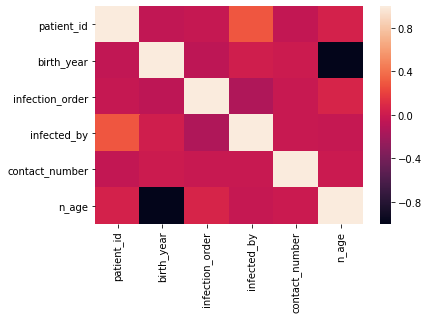

In [17]:
# correlation heat map for the features
ax = sns.heatmap(df.corr())

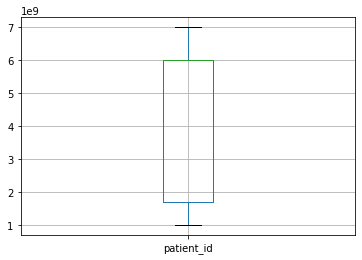

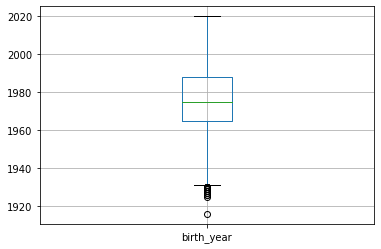

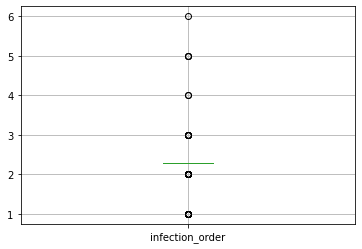

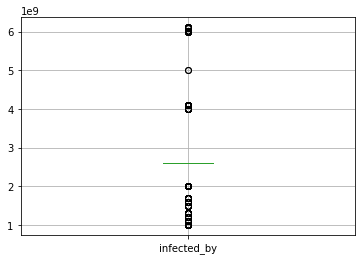

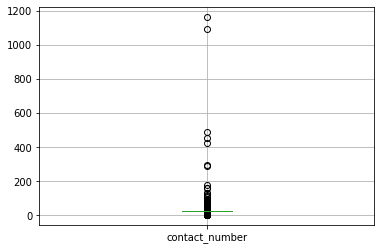

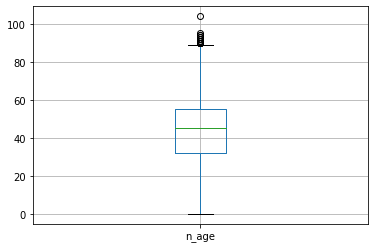

In [18]:
# boxplots to check for outliers
for c in df.select_dtypes(include=['float64','int64']).columns: 
    df.boxplot(column=c)
    plt.show()

In [19]:
#Define X and y
y = df['state']
X = df.drop('state',axis=1)
X = pd.get_dummies(X, drop_first=True)

### Scale data to prep for model creation

In [20]:
#scale data
from sklearn import preprocessing
import numpy as np
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X) 

### Split the data into test and train subsamples

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.8, random_state=1)

In [22]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier

In [23]:
import time
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
print('Training Data Set 1 Random Forest: Accuracy=%.3f' % (ac))
print('Training Data Set 1 Random Forest: f1-score=%.3f' % (f1))

Training Data Set 1 Random Forest: Accuracy=0.839
Training Data Set 1 Random Forest: f1-score=0.798


### Create Confusion Matrix Plots

In [24]:
class_names=['isolated','released','deceased'] # name  of classes

Confusion matrix, without normalization
[[  15    8    0    0]
 [   0 1398   26   10]
 [   0  221   27    1]
 [   0   20    0   49]]
Normalized confusion matrix
[[0.65 0.35 0.   0.  ]
 [0.   0.97 0.02 0.01]
 [0.   0.89 0.11 0.  ]
 [0.   0.29 0.   0.71]]


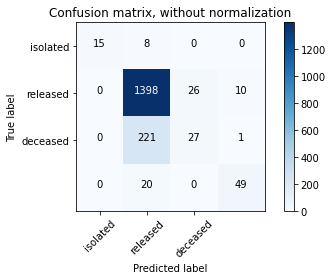

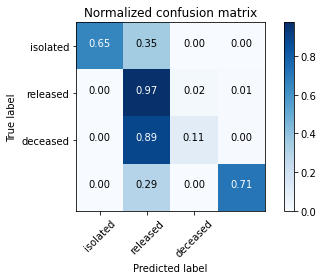

In [25]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances

30


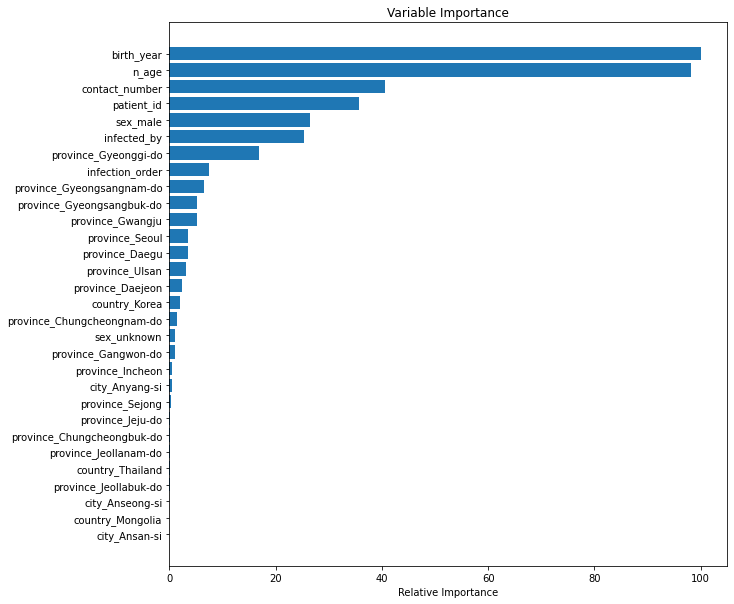

In [26]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model does not. In this case study, we see the performance ability even with only a few features and almost all of them were highly correlated with each other.